# Import libraries

In [486]:
# 0. Import
import os
from re import search
from dfply import *
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import importlib

from pathlib import Path

In [487]:
import celloracle as co
co.__version__

'0.8.0'

In [488]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [489]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Load settings

In [490]:
os.uname()[1]

'BI2404M'

In [491]:
if search("BI2404M", os.uname()[1]):
    exec(open('/Users/argelagr/gastrulation_multiome_10x/settings.py').read())
    exec(open('/Users/argelagr/gastrulation_multiome_10x/utils.py').read())
else:
    exit("Computer not recognised")

## Define I/O

In [609]:
# io['anndata'] = Path(io["basedir"]) / "results/rna_atac/rna_vs_acc/trajectories/blood_trajectory/anndata.h5ad"
io['metadata'] = Path(io["basedir"]) / "results/rna/metacells/trajectories/nmp/metacells_metadata.txt.gz"
io['anndata'] = Path(io["basedir"]) / "results/rna/metacells/trajectories/nmp/anndata_metacells.h5ad"
io['tf2gene'] = Path(io["basedir"]) / 'results/rna_atac/virtual_chipseq/metacells/trajectories/nmp/JASPAR/TF2gene_after_virtual_chip.txt.gz'
io["outdir"] = Path(io["basedir"]) / "results/rna_atac/gene_regulatory_networks/metacells/trajectories/nmp/celloracle"

## Define options 

scanpy options

In [494]:
# %%capture
# sc.settings.verbosity = 3
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(8, 7), facecolor='white')

In [495]:
opts["samples"] = [
#	"E7.5_rep1",
#	"E7.5_rep2",
#	"E7.75_rep1",
	"E8.0_rep1",
	"E8.0_rep2",
	"E8.5_rep1",
	"E8.5_rep2",
	"E8.75_rep1",
	"E8.75_rep2",
#	"E8.5_CRISPR_T_KO",
	"E8.5_CRISPR_T_WT"
]

# opts["samples"] = ["E8.5_rep1"]

opts["celltypes"] = ["Caudal_Mesoderm", "Somitic_mesoderm", "NMP", "Spinal_cord"]

# Load data


In [496]:
metadata = (pd.read_table(io["metadata"]) >>
    mask(X["sample"].isin(opts["samples"]), X["celltype"].isin(opts["celltypes"]))
).set_index("metacell", drop=False)
metadata.shape

(320, 8)

In [497]:
# adata = load_adata(
#     adata_file = io["anndata"], 
#     metadata_file = io["metadata"], 
#     cells = metadata.index.values, 
#     normalise = True, 
#     keep_counts = True,
# 	filter_lowly_expressed_genes = True, 
# 	set_colors = False
# )
adata = load_adata(
    adata_file = io['anndata'], 
    normalise = True, 
    keep_counts = True,
	set_colors = False
)
adata

AnnData object with n_obs × n_vars = 372 × 32285
    obs: 'sample', 'stage', 'genotype', 'celltype', 'closest.cell', 'ncells', 'nFeature_RNA'
    var: 'gene'
    uns: 'log1p'
    layers: 'raw'

In [498]:
colPalette_celltypes = [opts["celltype_colors"][i.replace(" ","_")] for i in sorted(np.unique(adata.obs['celltype']))]
adata.uns['celltype_colors'] = colPalette_celltypes

colPalette_celltypes = [opts["stage_colors"][i.replace(" ","_")] for i in sorted(np.unique(adata.obs['stage']))]
adata.uns['stage_colors'] = colPalette_celltypes

In [499]:
adata.X[:5,:5].todense()

matrix([[1.4501321, 0.       , 0.       , 0.       , 0.       ],
        [2.3794246, 0.       , 1.0851005, 0.       , 0.       ],
        [1.4996502, 0.       , 0.       , 0.       , 0.       ],
        [2.3194568, 0.       , 0.       , 0.       , 0.7025555],
        [1.5096446, 0.       , 0.       , 0.       , 0.       ]],
       dtype=float32)

## Feature selection

In [500]:
sc.pp.highly_variable_genes(adata, n_top_genes=25000)

Subset anndata with highly variable genes

In [501]:
adata = adata[:,adata.var["highly_variable"]]
adata

View of AnnData object with n_obs × n_vars = 372 × 31589
    obs: 'sample', 'stage', 'genotype', 'celltype', 'closest.cell', 'ncells', 'nFeature_RNA'
    var: 'gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'celltype_colors', 'stage_colors', 'hvg'
    layers: 'raw'

In [502]:
np.isin(np.array(["Sox2","T"]),adata.var_names)

array([ True,  True])

## PCA

In [503]:
sc.tl.pca(adata, n_comps=15, svd_solver='arpack')

## Batch effect correction

In [504]:
# sc.external.pp.harmony_integrate(adata, "stage", basis='X_pca', adjusted_basis='X_pca_harmony')

## k-NN graph

In [505]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=15, use_rep="X_pca")

## Force-directed layout

In [506]:
sc.tl.draw_graph(adata, layout='fa', init_pos=None)

In [507]:
adata.obsm["X_draw_graph_fa"] = pd.read_csv("/Users/argelagr/data/gastrulation_multiome_10x/test/results/rna/metacells/trajectories/nmp/metacell_trajectory.txt.gz", sep="\t", index_col=0).loc[adata.obs.index.values].values

In [508]:
adata.obsm

AxisArrays with keys: X_pca, X_draw_graph_fa

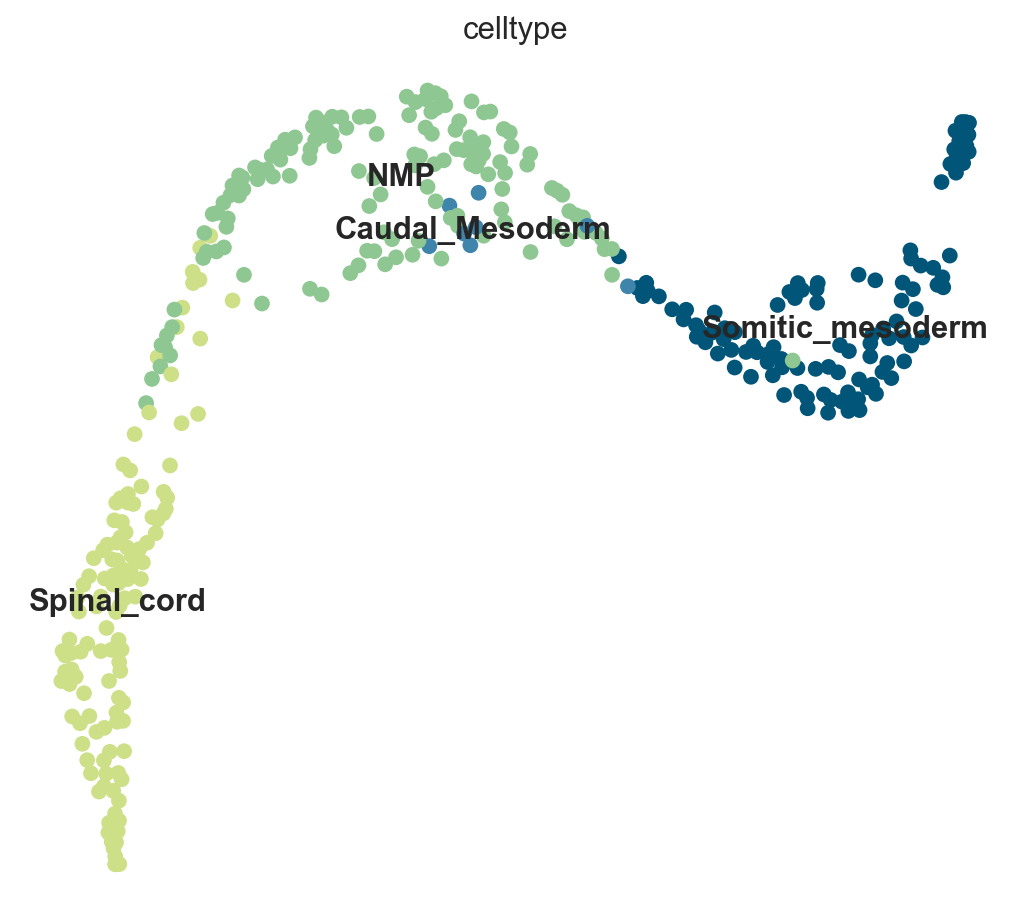

In [509]:
sc.pl.draw_graph(adata, color=["celltype"], size=200, legend_loc="on data")

## Prepare data for celloracle

In [510]:
adata.X = adata.layers["raw"].copy()
adata.X[1:5,1:5].todense()

matrix([[0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]], dtype=float32)

In [511]:
TF_markers_pandas = pd.read_csv("/Users/argelagr/data/gastrulation10x/results/differential/celltypes/TFs/TF_markers/marker_TFs_upregulated_all.txt.gz", sep="\t") >> (
    mask(X["score"]>=0.75, X["celltype"].isin(opts["celltypes"])) >>
    mutate(gene=X["gene"].str.upper())
)

TFs = np.unique(TF_markers_pandas.gene.values)
TFs

array(['CDX1', 'CDX2', 'CDX4', 'ETV4', 'EVX1', 'FOXB1', 'FOXC1', 'FOXC2',
       'GBX2', 'HES5', 'HES7', 'HOXA1', 'HOXA2', 'HOXA3', 'HOXA5',
       'HOXA7', 'HOXA9', 'HOXB1', 'HOXB4', 'HOXB6', 'HOXB7', 'HOXB8',
       'HOXB9', 'HOXC4', 'HOXC6', 'HOXC8', 'HOXC9', 'HOXD4', 'IRX2',
       'LEF1', 'MEIS2', 'MEOX1', 'MIXL1', 'NR6A1', 'PAX6', 'RARB', 'RARG',
       'RXRG', 'SOX2', 'SP5', 'T', 'TCF15'], dtype=object)

Load TF2gene links

In [512]:
tf2gene_df = pd.read_csv(io['tf2gene'],header=0, sep="\t")
tf2gene_df

,peak,tf,chip_score,gene,dist
0,chr10:117108619-117109219,ALX3,0.16,Cct2,45105
1,chr10:117108619-117109219,ALX3,0.16,Frs2,0
2,chr10:117207890-117208490,ALX3,0.15,Gm26311,24779
3,chr10:117207890-117208490,ALX3,0.15,Yeats4,6952
4,chr10:117207890-117208490,ALX3,0.15,9530003J23Rik,24047
...,...,...,...,...,...
377765,chr8:105325999-105326599,ZKSCAN5,0.19,Slc9a5,22544
377766,chr8:105325999-105326599,ZKSCAN5,0.19,Plekhg4,46975
377767,chr12:117627203-117627803,ZSCAN29,0.16,Rapgef5,0
377768,chr2:118533321-118533921,ZSCAN29,0.16,Gm13983,49444


In [513]:
TFs

array(['CDX1', 'CDX2', 'CDX4', 'ETV4', 'EVX1', 'FOXB1', 'FOXC1', 'FOXC2',
       'GBX2', 'HES5', 'HES7', 'HOXA1', 'HOXA2', 'HOXA3', 'HOXA5',
       'HOXA7', 'HOXA9', 'HOXB1', 'HOXB4', 'HOXB6', 'HOXB7', 'HOXB8',
       'HOXB9', 'HOXC4', 'HOXC6', 'HOXC8', 'HOXC9', 'HOXD4', 'IRX2',
       'LEF1', 'MEIS2', 'MEOX1', 'MIXL1', 'NR6A1', 'PAX6', 'RARB', 'RARG',
       'RXRG', 'SOX2', 'SP5', 'T', 'TCF15'], dtype=object)

Filter target genes to also be TFs

In [514]:
tf2gene_df = pd.read_csv(io['tf2gene'],header=0, sep="\t") >> (
    mask(X["chip_score"]>=0.20, X["dist"]<=50000) >> 
    mask(X["gene"].str.upper().isin(TFs),X["tf"].str.upper().isin(TFs)) >> 
    select([1,3]) >> 
    mutate(gene=X["gene"].str.upper())
)
tf2gene_df.shape

(1614, 2)

Filter TF2gene links

In [515]:
tf2gene_df.head()

,tf,gene
2038,CDX1,MEOX1
2418,CDX1,HES7
2428,CDX1,HES7
2604,CDX1,HOXB9
2605,CDX1,HOXB8


Filter genes in the anndata object

In [516]:
tf2gene_df["gene"].values

array(['MEOX1', 'HES7', 'HES7', ..., 'LEF1', 'CDX2', 'CDX4'], dtype=object)

In [517]:
all_genes = np.unique(np.concatenate((tf2gene_df["tf"].values,tf2gene_df["gene"].values)))
len(all_genes)
# adata.var.index.str.upper().isin()

41

In [518]:
adata.var.index = adata.var.index.str.upper()
adata = adata[:,all_genes]

In [519]:
tmp = adata.var["gene"].str.upper().isin(tf2gene_df["tf"].values).values
adata.var["gene"][tmp] = adata.var["gene"][tmp].str.upper()

In [520]:
adata.var["gene"].str.upper().isin(tf2gene_df["tf"].values).sum()

27

Filter TFs

In [521]:
tf2gene_df = tf2gene_df[tf2gene_df["tf"].isin(adata.var_names)]
tf2gene_df.shape

(1614, 2)

Filter genes

In [522]:
tf2gene_df = tf2gene_df[tf2gene_df["gene"].isin(adata.var_names)]
tf2gene_df.shape

(1614, 2)

Convert to a dictionary

In [523]:
tf2gene_dic = tf2gene_df.groupby('gene')['tf'].apply(lambda x: x.tolist()).to_dict()

In [524]:
# np.isin(np.array(list(tf2gene_dic.keys())),adata.var_names).sum()
len(tf2gene_dic.keys())

40

# 2. Initiate Oracle object

In [525]:
oracle = co.Oracle()

## Load gene expression data into oracle object.

In [526]:
adata.var["symbol"] = adata.var.index.values
#adata.var["isin_top1000_var_mean_genes"] = True

Trying to set attribute `.var` of view, copying.


create dummy column

In [527]:
adata.obs["foo"] = "foo"
adata.obs["foo"] = adata.obs["foo"].astype('category')

In [528]:
adata.uns["foo_colors"] = np.array(["#9e6762"])

Check adata object

In [529]:
adata.obsm

AxisArrays with keys: X_pca, X_draw_graph_fa

In [530]:
oracle.import_anndata_as_raw_count(adata=adata, cluster_column_name="foo", embedding_name="X_draw_graph_fa")

## 2.2. Load TFinfo into oracle object

In [531]:
oracle.import_TF_data(TFdict=tf2gene_dic)

Total number of TF was 27. Although we can go to the GRN calculation with this data, but the TF number is small.


In [532]:
#oracle.adata.var.loc[:,["isin_TFdict_targets","isin_TFdict_regulators"]]
oracle.adata.var.loc[:,"isin_TFdict_targets"].sum()

40

In [533]:
oracle.adata.var.loc[:,"isin_TFdict_regulators"].sum()

27

## Knn imputation

PCA

In [534]:
# Perform PCA
# oracle.perform_PCA()

# Select important PCs
# plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
# n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
# plt.axvline(n_comps, c="k")

KNN imputation. It creates the attributes:
- knn (scipy.sparse.csr_matrix): knn contiguity matrix
- knn_smoothing_w (scipy.sparse.lil_matrix): the weights used for the smoothing

In [535]:
# k = 25
# oracle.knn_imputation(n_pca_dims=15, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=4)
# oracle.knn.shape

In [536]:
# oracle.adata.layers

In [537]:
oracle.adata.layers["normalized_count"].todense()[:5,:5]

matrix([[3.1780539, 3.3322046, 3.0445225, 3.871201 , 1.9459101],
        [2.7080503, 3.1780539, 2.944439 , 3.7376697, 2.1972246],
        [2.7725887, 3.3322046, 3.3322046, 2.944439 , 2.3978953],
        [2.7725887, 2.1972246, 2.1972246, 2.1972246, 1.0986123],
        [1.3862944, 0.6931472, 0.6931472, 0.6931472, 1.3862944]],
       dtype=float32)

## GRN calculation
The next step is constructing a cluster-specific GRN for all clusters.

The "get_links" function returns GRNs as a Links object which stores inferred GRNs and the corresponding metadata. You can do network analysis with the Links object.

In [538]:
importlib.reload(co)
# co.__file__

1 package does not meet CellOracle requirement.
 Your h5py version is 2.10.0. Please install h5py>=3.1.0


<module 'celloracle' from '/Users/argelagr/git/CellOracle/celloracle/__init__.py'>

In [539]:
links = oracle.get_links(cluster_name_for_GRN_unit="foo", alpha=10, verbose_level=10, test_mode=False)
links

  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for foo...


  0%|          | 0/40 [00:00<?, ?it/s]

In [540]:
links.links_dict["foo"].shape

(473, 6)

In [541]:
links.links_dict["foo"]

,source,target,coef_mean,coef_abs,p,-logp
0,LEF1,CDX1,0.175833,0.175833,1.142619e-06,5.942099
1,CDX2,CDX1,0.530312,0.530312,1.802656e-14,13.744087
2,T,CDX1,-0.201108,0.201108,5.811875e-07,6.235684
3,CDX4,CDX1,-0.056012,0.056012,2.349217e-02,1.629077
4,ETV4,CDX1,0.408427,0.408427,3.626911e-11,10.440463
...,...,...,...,...,...,...
468,HOXA5,T,-0.058554,0.058554,5.797807e-06,5.236736
469,ETV4,T,0.298311,0.298311,3.676211e-09,8.434600
470,SOX2,TCF15,-0.002410,0.002410,8.428322e-01,0.074259
471,FOXC1,TCF15,0.241971,0.241971,3.507155e-04,3.455045


### Exploration

In [542]:
links.filter_links(p=0.0001, weight="coef_abs")
links.links_dict["foo"].shape

(473, 6)

## Save

In [543]:
io['links_outfile'] = io['outdir'] / 'test.celloracle.links'
# links.to_hdf5(str(io['links_outfile']))

In [544]:
io['oracle_outfile'] = io['outdir'] / "test.celloracle.oracle"
# oracle.to_hdf5(str(io['oracle_outfile']))

# Explore

In [545]:
links.links_dict["foo"] >> mask(X.source=="T") >> arrange("coef_mean")

,source,target,coef_mean,coef_abs,p,-logp
383,T,IRX2,-0.336460,0.336460,5.339490e-10,9.272500
2,T,CDX1,-0.201108,0.201108,5.811875e-07,6.235684
277,T,HOXB9,-0.183455,0.183455,1.770981e-08,7.751786
236,T,HOXB7,-0.029951,0.029951,4.300597e-02,1.366471
217,T,HOXB6,-0.024516,0.024516,7.496842e-02,1.125122
204,T,HOXB4,-0.022046,0.022046,1.785094e-01,0.748339
292,T,HOXC4,-0.005629,0.005629,7.376692e-01,0.132138
188,T,HOXB1,0.028969,0.028969,3.974306e-02,1.400739
311,T,HOXC6,0.052016,0.052016,1.236032e-03,2.907970
255,T,HOXB8,0.059592,0.059592,7.338009e-05,4.134422


In [546]:
links.links_dict["foo"] >> mask(X.source=="SOX2") >> arrange("coef_mean")

,source,target,coef_mean,coef_abs,p,-logp
392,SOX2,LEF1,-0.134021,0.134021,8.837338e-05,4.053679
271,SOX2,HOXB8,-0.007083,0.007083,4.185406e-01,0.378262
470,SOX2,TCF15,-0.002410,0.002410,8.428322e-01,0.074259
233,SOX2,HOXB6,0.007189,0.007189,4.264417e-01,0.370140
196,SOX2,HOXB1,0.014025,0.014025,6.547819e-01,0.183903
148,SOX2,HOXA5,0.026885,0.026885,2.373338e-03,2.624640
252,SOX2,HOXB7,0.052900,0.052900,7.770664e-06,5.109542
75,SOX2,GBX2,0.073793,0.073793,3.153009e-08,7.501275
214,SOX2,HOXB4,0.090939,0.090939,4.033792e-05,4.394286
136,SOX2,HOXA3,0.095219,0.095219,1.498100e-06,5.824459


In [547]:
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)

In [548]:
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in foo


  0%|          | 0/41 [00:00<?, ?it/s]

genes_in_gem: 41
models made for 40 genes


In [632]:
gene = "T"

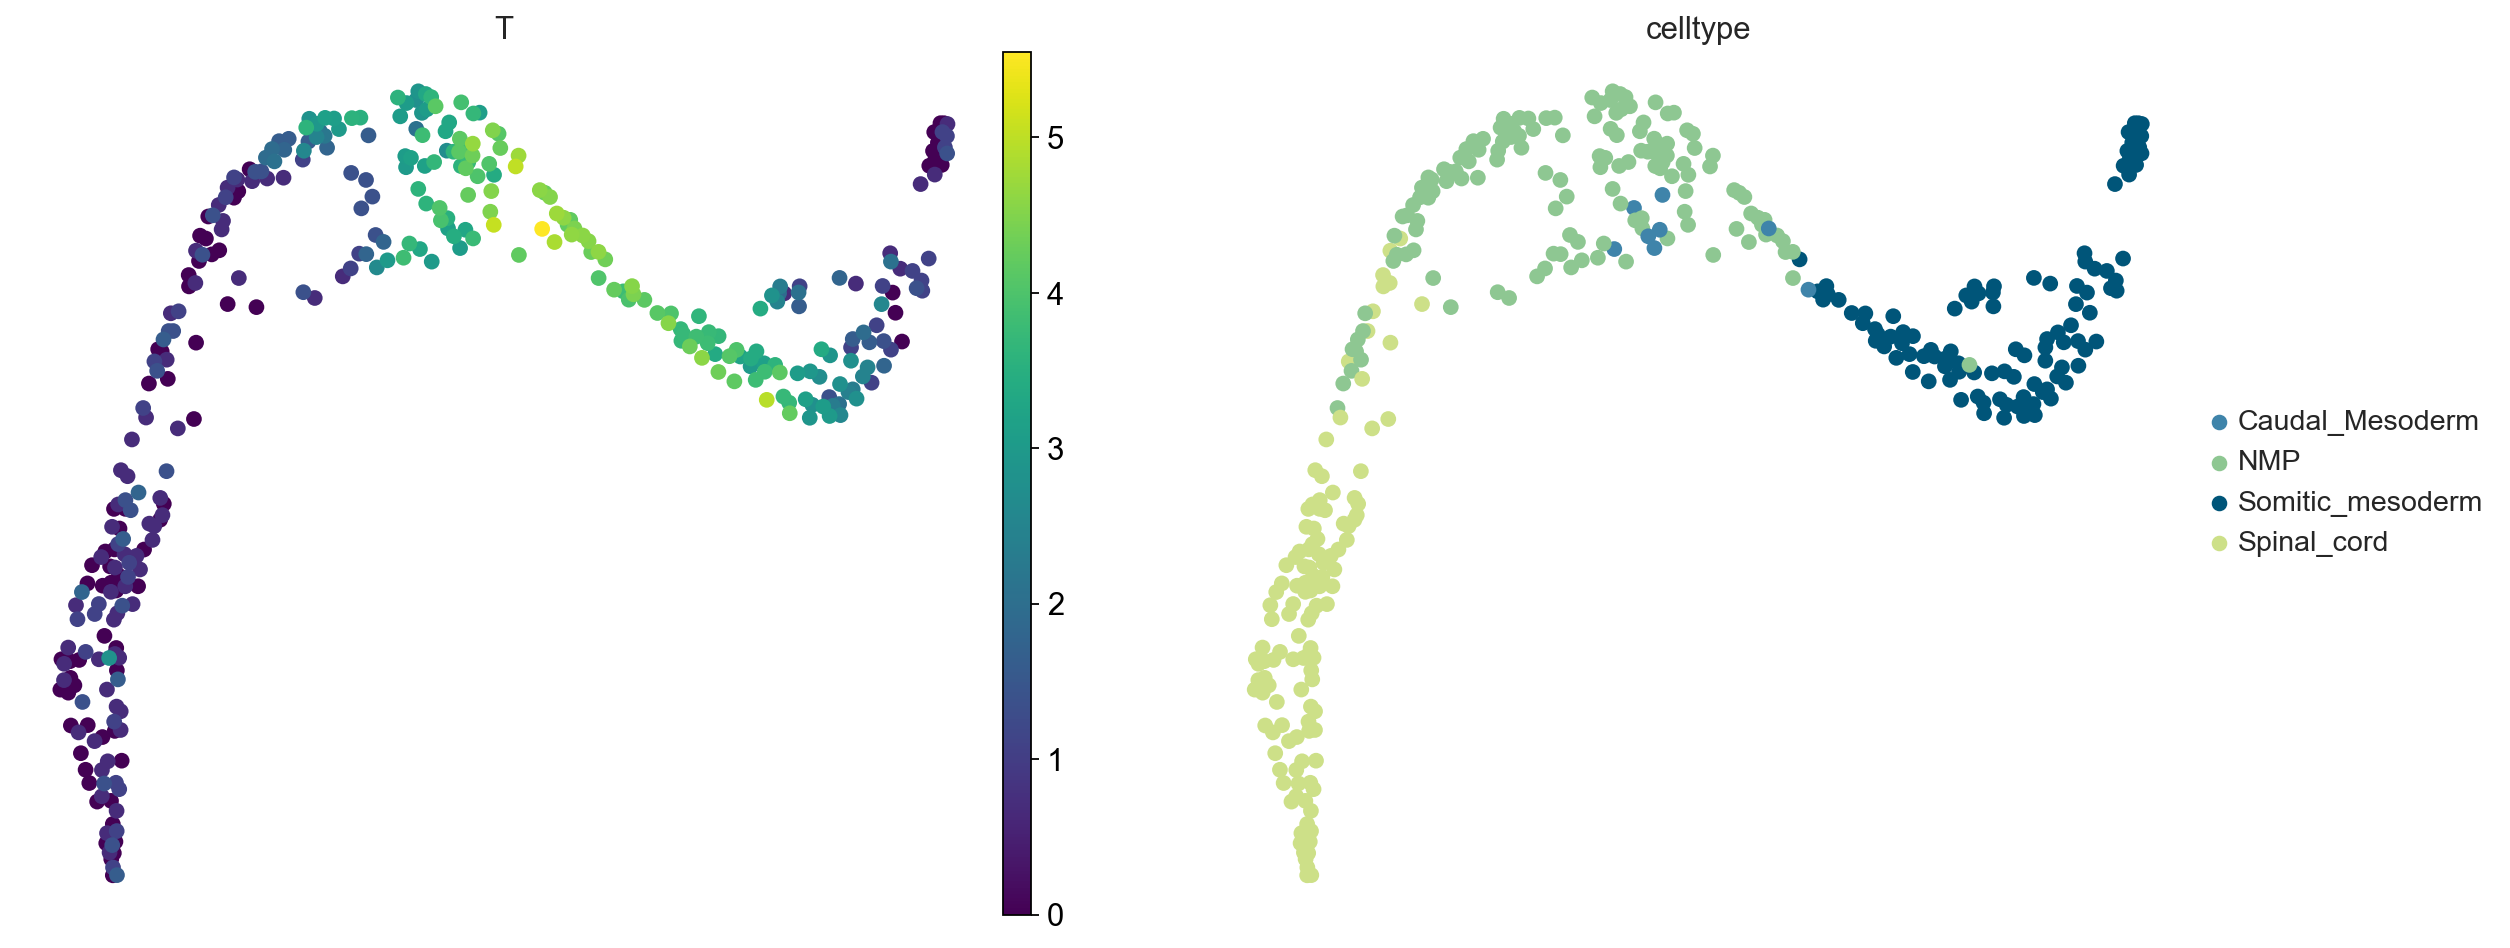

In [633]:
sc.pl.draw_graph(oracle.adata, color=[gene,'celltype'], size=200, layer="normalized_count", cmap="viridis")

In [634]:
oracle.simulate_shift(perturb_condition={gene: 0.0}, n_propagation=3)

In [635]:
oracle.estimate_transition_prob(n_neighbors=15, knn_random=True, sampled_fraction=1)

In [636]:
oracle.calculate_embedding_shift(sigma_corr = 0.05)

In [637]:
oracle.calculate_p_mass(smooth=0.8, n_grid=40, n_neighbors=15)

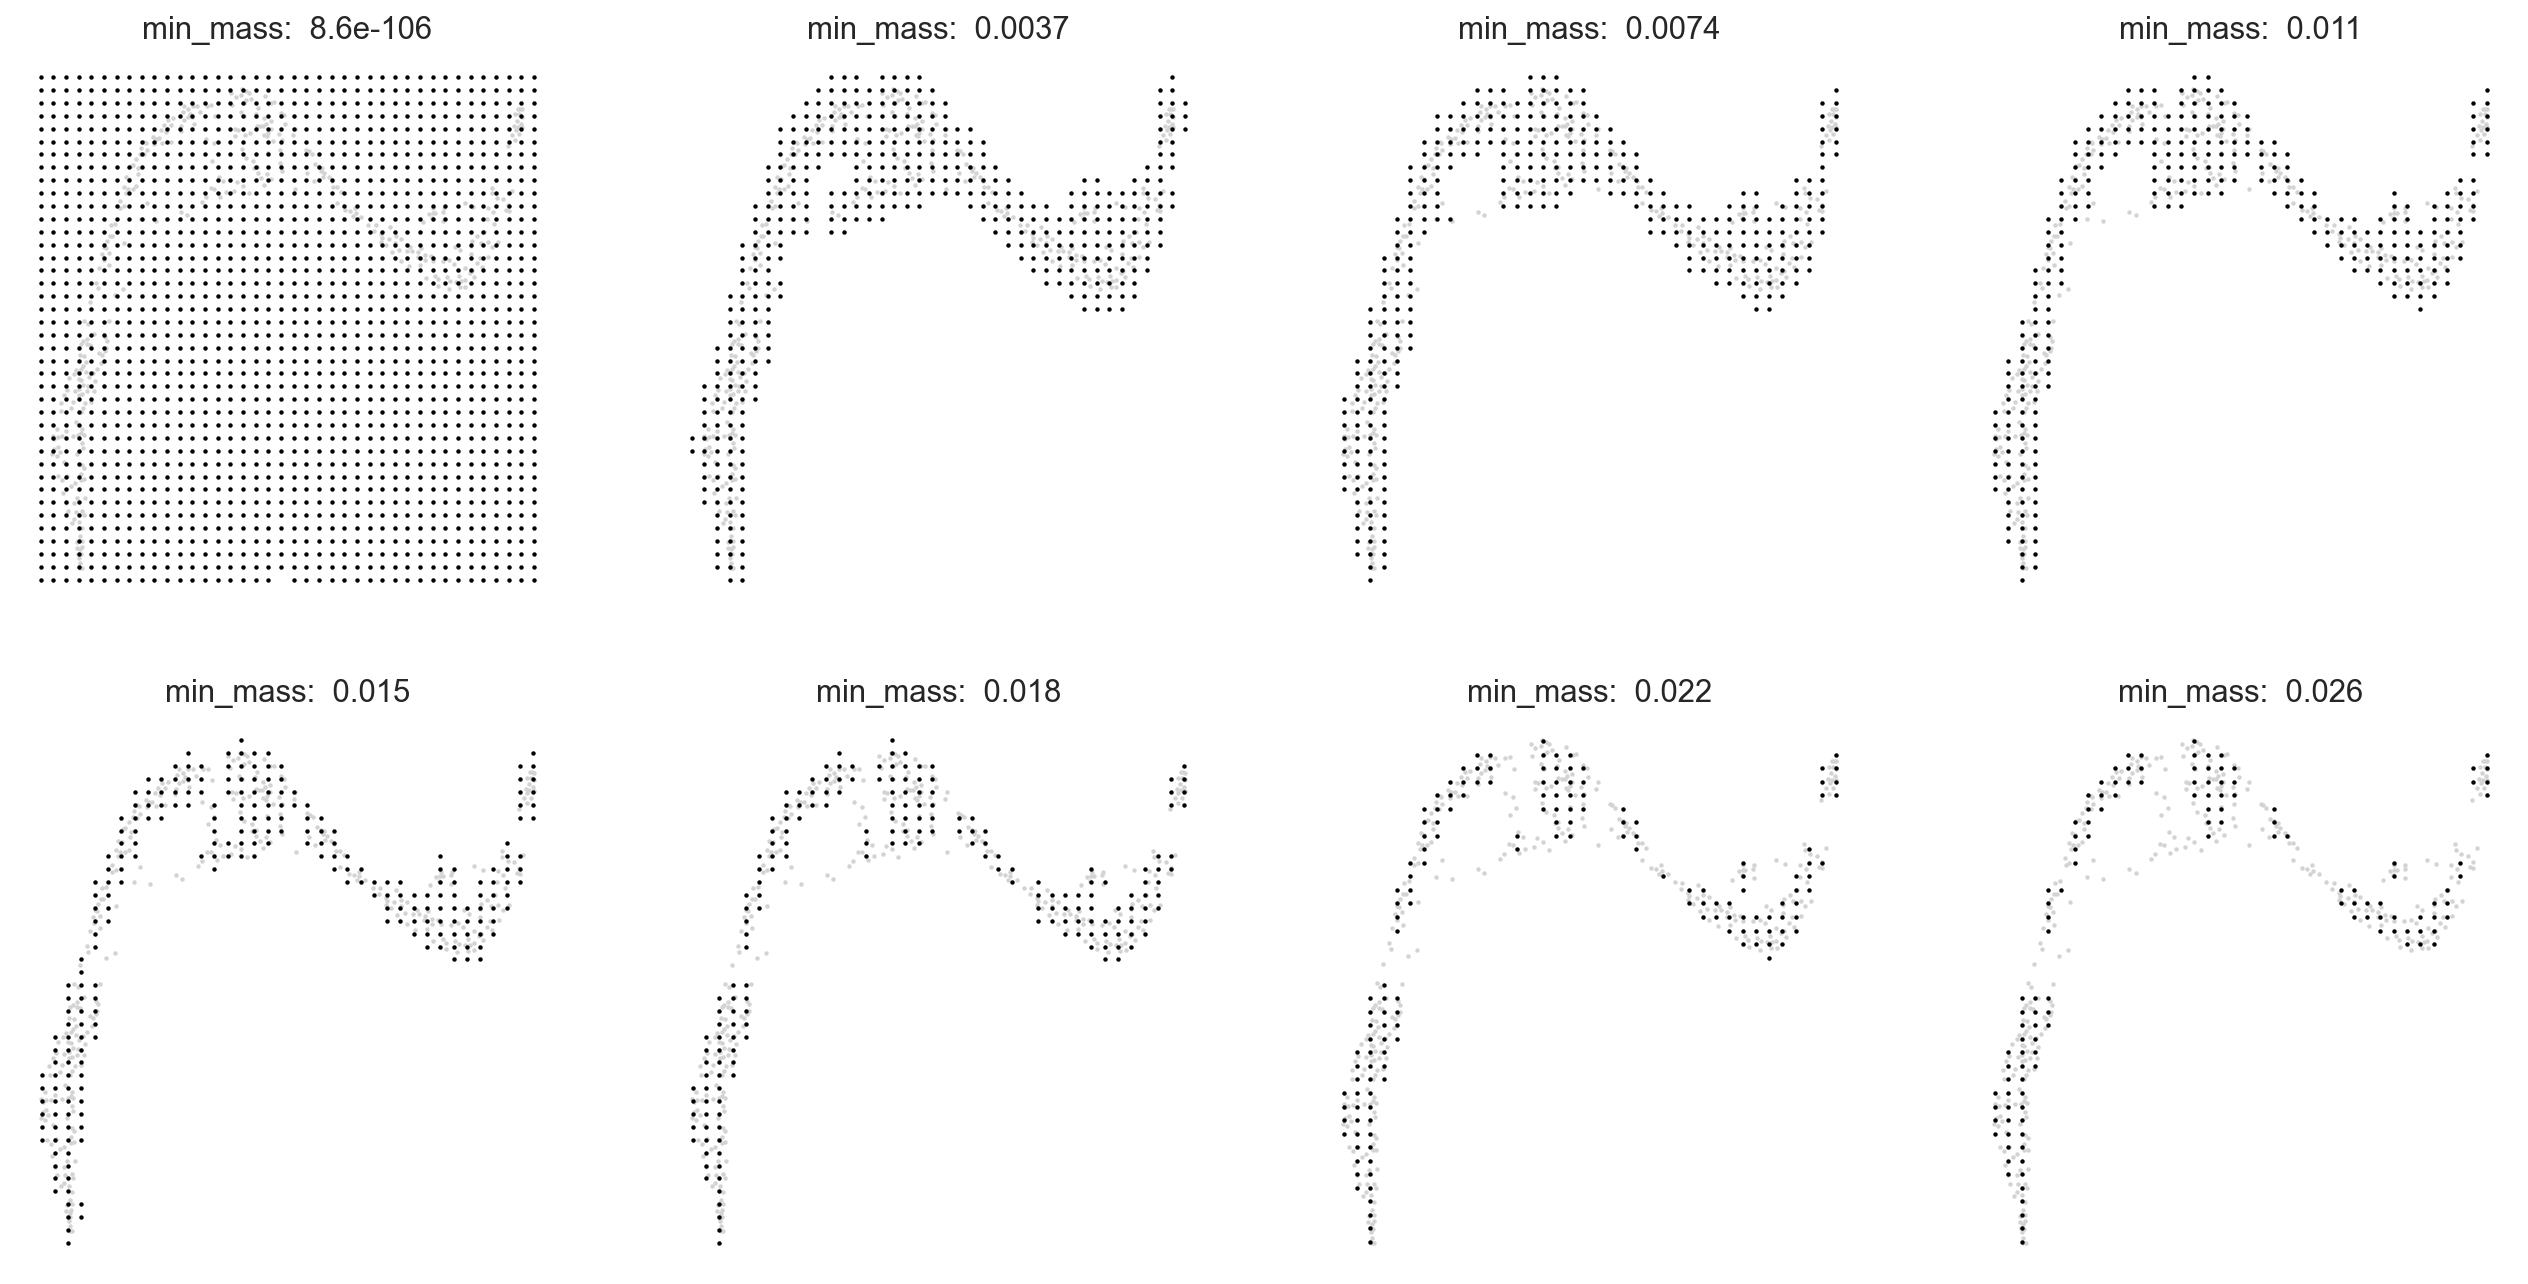

In [638]:
oracle.suggest_mass_thresholds(n_suggestion=8)

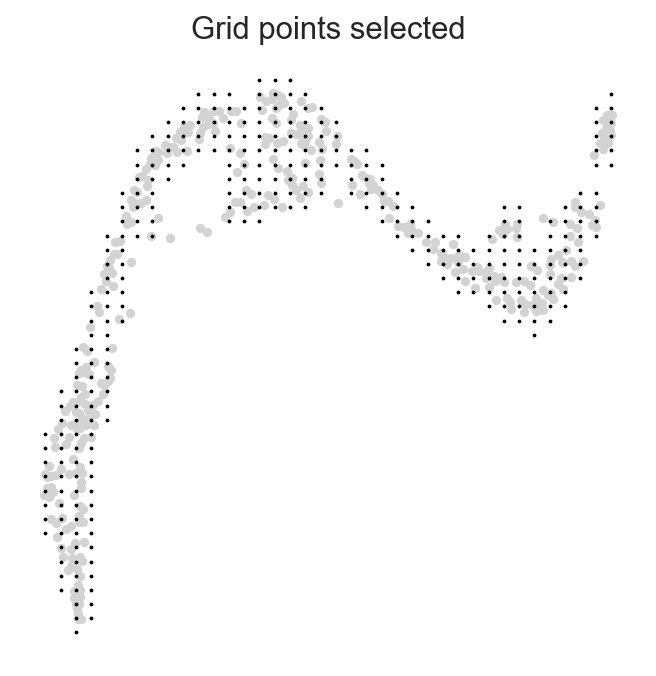

In [639]:
oracle.calculate_mass_filter(min_mass=0.01, plot=True)

In [640]:
scale_simulation = 0.55

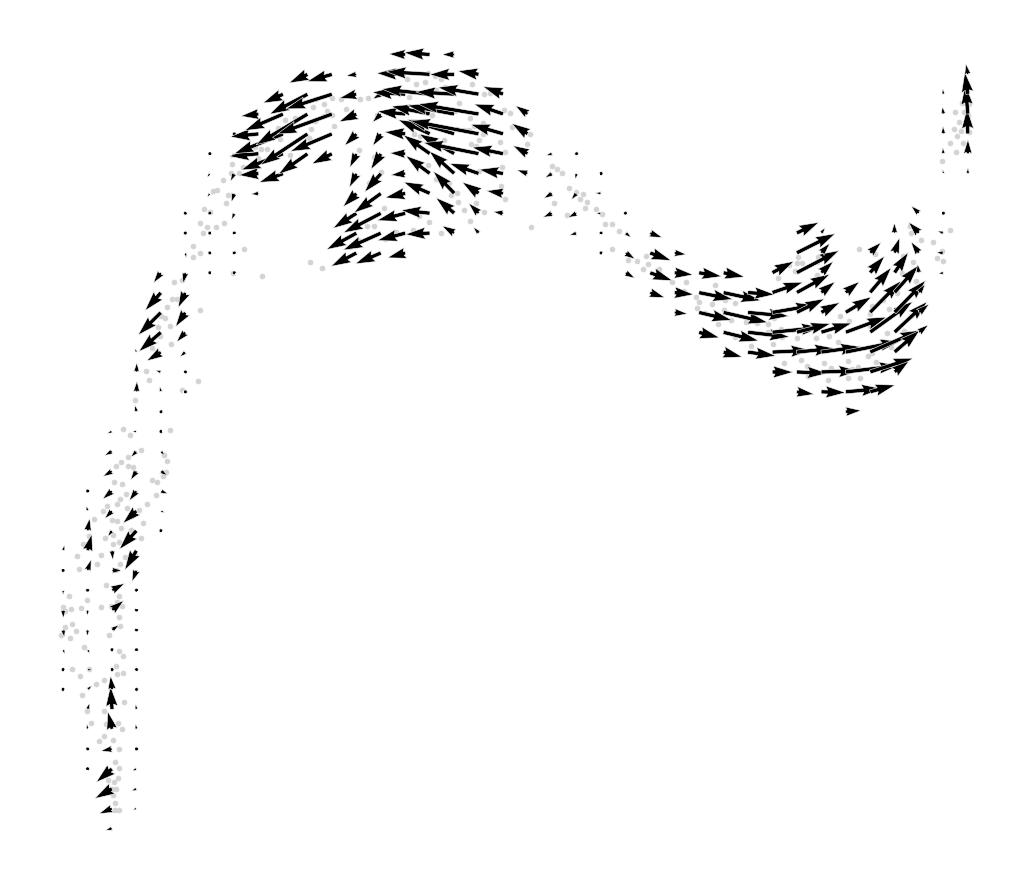

In [641]:
oracle.plot_simulation_flow_on_grid(scale=scale_simulation)

In [642]:
# fig, ax = plt.subplots(1, 2,  figsize=[15, 7])
# oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
# ax[0].set_title(f"Perturbation simulation results: {gene} KO")
# oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
# ax[1].set_title(f"Perturbation simulation with randomized GRNs")
# plt.show()

In [643]:
cell_colors = [opts["celltype_colors"][i] for i in oracle.adata.obs["celltype"].values]

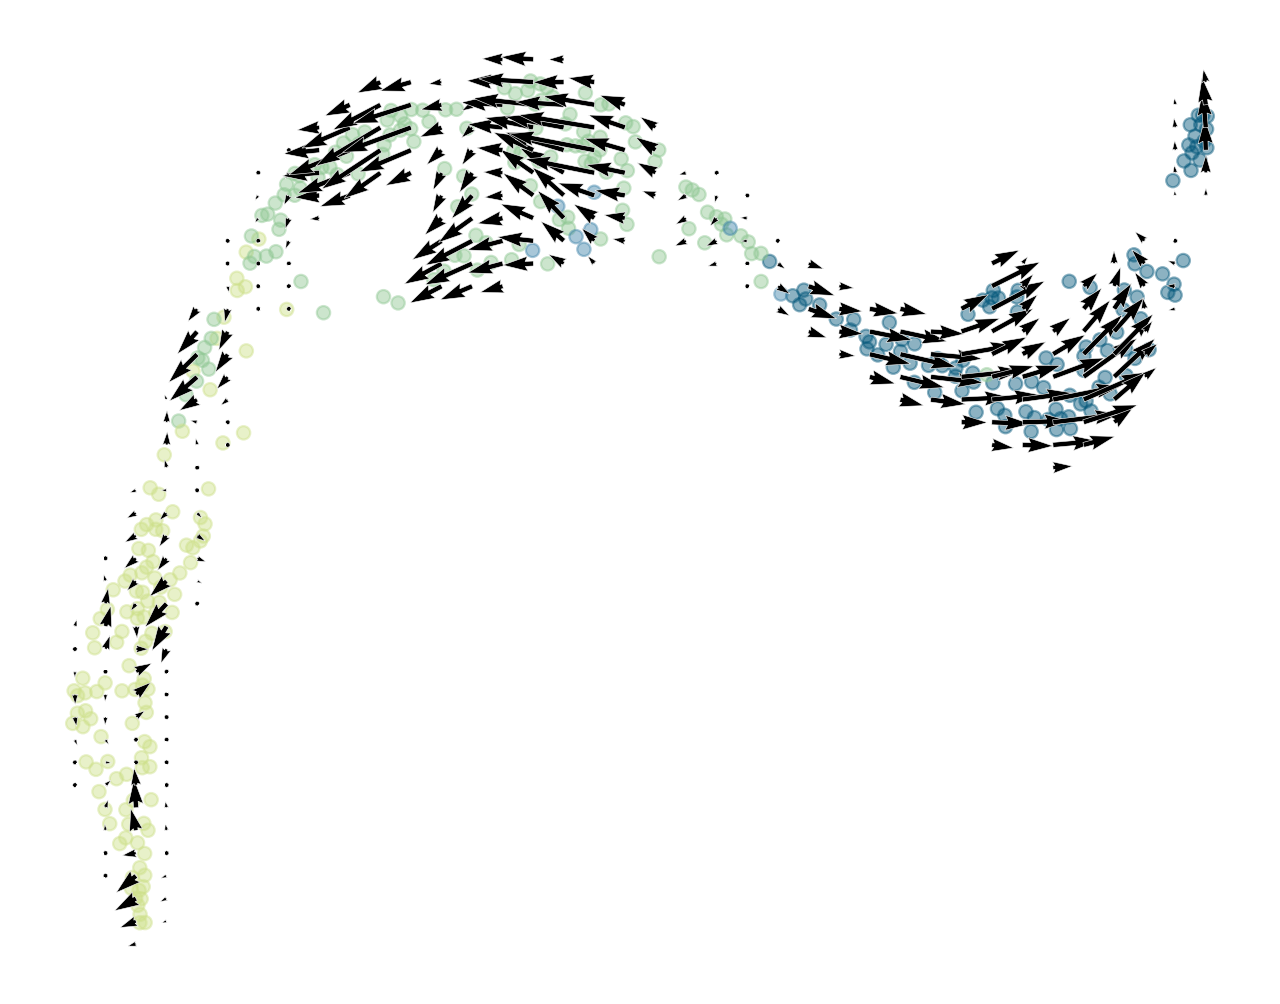

In [644]:
fig, ax = plt.subplots(figsize=[10, 8])
ax.scatter(oracle.embedding[:,0], oracle.embedding[:,1], c=cell_colors, alpha=0.45)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)
plt.savefig(io['outdir'] / "test.pdf")